# Map water bodies in Tasselled Cap 3D space

- Wetness is used to define wet areas
- Greenness should be used to remove forests
- Brightness can be used used to remove birght artifical surfaces

### Import Modules

In [1]:
import xarray as xr
import matplotlib.pyplot as plt

### Load in data

In [2]:
# Choose your area of interest
# Sydney 17_-39
# Arafura 3_-14
# Kakadu 0_-13
# Mac Marshes 14_-35
tile = '12_-47'

# Select a band
# Bands 0, 1, 2 and 3 = 10th, 50th, 90th and 95th percentile
band = 0 

In [3]:
# Set folder location
TileFolder = 'dev/dea-notebooks/Gabrielle_dev/LCCS_wet_veg/tas_tiles/'

In [6]:
pwd

'/home/jovyan/dev/dea-notebooks/Gabrielle_dev/LCCS_wet_veg/tas_tiles'

In [7]:
# Open into an xarray.DataArray
wet = xr.open_rasterio(f'LS_TCW_PC_{tile}_1986_2020_summary.tif')
green = xr.open_rasterio(f'LS_TCG_PC_{tile}_1986_2020_summary.tif')
# bright = xr.open_rasterio(f'{TileFolder}LS_TCB_PC_{tile}_1986_2020_summary.tif')

In [8]:
wet

<xarray.DataArray (band: 4, y: 4000, x: 4000)>
[64000000 values with dtype=int16]
Coordinates:
  * band     (band) int64 1 2 3 4
  * y        (y) float64 -4.6e+06 -4.6e+06 -4.6e+06 ... -4.7e+06 -4.7e+06
  * x        (x) float64 1.2e+06 1.2e+06 1.2e+06 ... 1.3e+06 1.3e+06 1.3e+06
Attributes:
    transform:      (25.0, 0.0, 1200000.0, 0.0, -25.0, -4600000.0)
    crs:            +init=epsg:3577
    res:            (25.0, 25.0)
    is_tiled:       1
    nodatavals:     (-9999.0, -9999.0, -9999.0, -9999.0)
    scales:         (1.0, 1.0, 1.0, 1.0)
    offsets:        (0.0, 0.0, 0.0, 0.0)
    AREA_OR_POINT:  Area
    created:        {'lineage': {'algorithm': {'name': 'datacube-stats', 'ver...

In [9]:
# # Set up subplots
# f, axarr = plt.subplots(2, 2, figsize=(13, 11))

# wet.isel(band=band).plot(cmap='Blues', vmin=-6000, vmax=1000, add_colorbar=True, ax=axarr[0, 0])
# axarr[0, 0].set_title('Wetness')

# green.isel(band=band).plot(cmap='Greens', vmin=-4000, vmax=4000, add_colorbar=True, ax=axarr[0, 1])
# axarr[0, 1].set_title('Greenness')

# bright.isel(band=band).plot(cmap='Reds', vmin=2000, vmax=18000, add_colorbar=True, ax=axarr[1, 0])
# axarr[1, 0].set_title('Brightness')

# # plt.imshow(wet.isel(band=0),cmap='Blues', vmin=-6000, vmax=1000)
# # plt.colorbar()

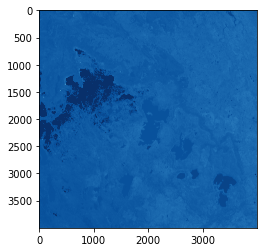

In [10]:
plt.imshow(wet.isel(band=3),cmap='Blues', vmin=-6000, vmax=1000)

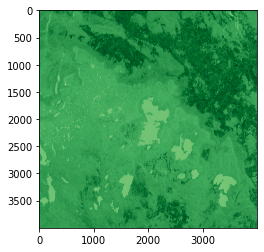

In [11]:
plt.imshow(green.isel(band=3),cmap='Greens', vmin=-4000, vmax=4000)

In [12]:
# plt.imshow(bright.isel(band=3),cmap='Reds', vmin=2000, vmax=18000)
# plt.colorbar()
# bright.isel(band=band).plot(size=11)

### Apply thresholds

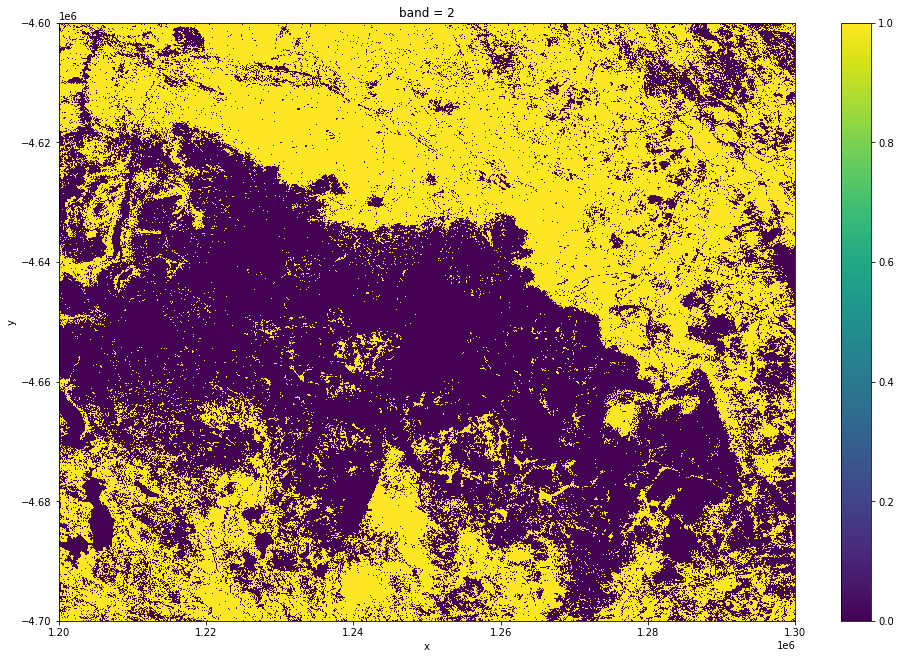

In [14]:
# Brightness
# vbright = bright.isel(band=band) > 18000
# vbright.plot(size=11)

# Greenness
vgreen = green.isel(band=1) > 1100
# vgreen.plot(size=11)

# Wetness
vwet = wet.isel(band=band) > -600
# vwet.plot(size=11)

# Greenness and brightness mask
gb_mask = vgreen #+ vbright
gb_mask.plot(size=11)

### Apply masks

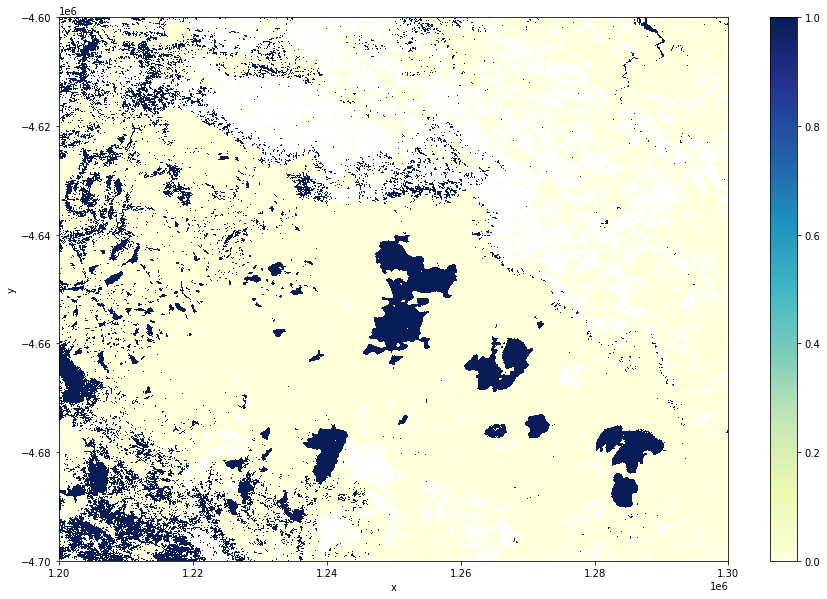

In [15]:
water = vwet.where(gb_mask != 1)
water.plot(size=10, cmap='YlGnBu')

### Add in slope

In [10]:
import datacube
dc = datacube.Datacube()

In [11]:
from datacube.utils.cog import write_cog
import richdem as rd
import pyproj
from odc.algo import xr_reproject
import datacube
import numpy as np
import sys
import xarray as xr
import matplotlib.pyplot as plt

sys.path.append('../Scripts')
from dea_bandindices import calculate_indices
# from deafrica_temporal_statistics import xr_phenology, temporal_statistics
# from datacube.utils.geometry import assign_crs

def xr_terrain(da, attribute=None):
    """
    Using the richdem package, calculates terrain attributes
    on a DEM stored in memory as an xarray.DataArray 
    
    Params
    -------
    da : xr.DataArray
    attribute : str
        One of the terrain attributes that richdem.TerrainAttribute()
        has implemented. e.g. 'slope_riserun', 'slope_percentage', 'aspect'.
        See all option here:  
        https://richdem.readthedocs.io/en/latest/python_api.html#richdem.TerrainAttribute
        
    """
    #remove time if its there
    da = da.squeeze()
    #convert to richdem array
    rda = rd.rdarray(da.data, no_data=da.attrs['nodata'])
    #add projection and geotransform
    rda.projection=pyproj.crs.CRS(da.attrs['crs']).to_wkt()
    rda.geotransform = da.geobox.affine.to_gdal()
    #calulate attribute
    attrs = rd.TerrainAttribute(rda, attrib=attribute)

    #return as xarray DataArray
    return xr.DataArray(attrs,
                        attrs=da.attrs,
                        coords={'x':da.x, 'y':da.y},
                        dims=['y', 'x'])


# def crop_features(ds):
#     dc = datacube.Datacube(app='training')
#     data = calculate_indices(ds,
#                              index=['NDVI'],
#                              drop=True,
#                              collection='s2')
    
#     #temporal stats
# #     ts = temporal_statistics(data.NDVI,
# #                        stats=['f_mean', 'abs_change',
# #                               'complexity','central_diff'])
#     ts = xr_phenology(data.NDVI, 
#                       stats=['Trough','vSOS', 'vPOS','AOS','ROG','ROS'],
#                       complete='fast_completion')

#     #rainfall climatology
#     chirps = assign_crs(xr.open_rasterio('data/CHIRPS/CHPclim_sum.nc'),  crs='epsg:4326')
#     chirps = xr_reproject(chirps,ds.geobox,"mode")
#     chirps = chirps.to_dataset(name='chirps')
    
#     #slope
#     slope = dc.load(product='srtm', like=ds.geobox).squeeze()
#     slope = slope.elevation
#     slope = xr_terrain(slope, 'slope_riserun')
#     slope = slope.to_dataset(name='slope')
    
#     #Surface reflectance results
#     sr = ds.median('time')
#     result = xr.merge([ts, sr, chirps,slope], compat='override')
#     result = assign_crs(result, crs=ds.geobox.crs)

#     return result.squeeze()

In [12]:
# Get tile bounds
def get_tile_bounds(tile):
    x, y = tile.split('_')
    minx = int(x) * 100000
    miny = int(y) * 100000
    maxx = minx + 100000
    maxy = miny + 100000
    return {'minx': minx, 'miny': miny, 'maxx': maxx, 'maxy': maxy}

bounds = get_tile_bounds(tile)
print(bounds)

{'minx': 1400000, 'miny': -3500000, 'maxx': 1500000, 'maxy': -3400000}


In [13]:
dem = dc.load(product='srtm_dem1sv1_0', 
                x=(bounds['minx'],bounds['maxx']),
                y=(bounds['miny'],bounds['maxy']),
                crs='EPSG:3577',
                output_crs = 'EPSG:3577',
                resolution=(-25, 25)).squeeze()


In [14]:
slope = dem.dem #no elevation
slope = xr_terrain(slope, 'slope_riserun')
slope = slope.to_dataset(name='slope')

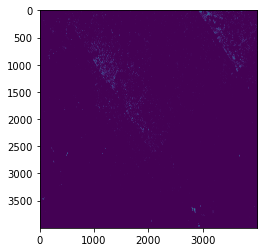

In [15]:
steep =  slope.slope > 0.2
np.unique(steep)
plt.imshow(steep)

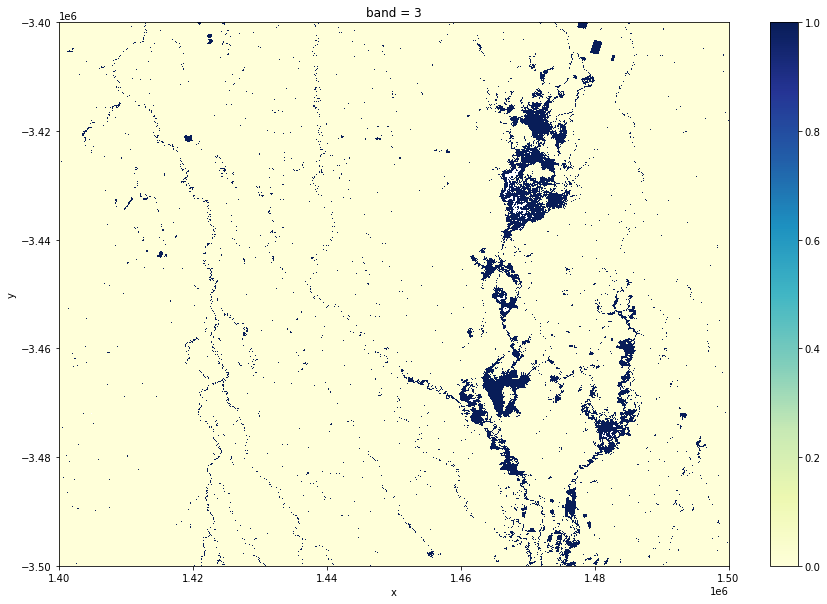

In [16]:
flat_water = water.where(steep != 1)
# plt.imshow(flat_water)
flat_water.plot(size=10, cmap='YlGnBu')

Text(0.5, 1.0, 'Flat water')

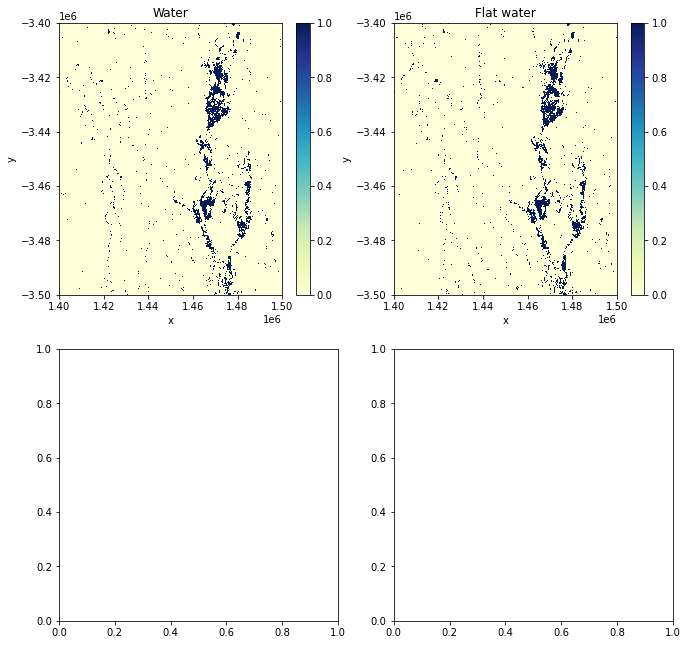

In [17]:
# Set up subplots
f, axarr = plt.subplots(2, 2, figsize=(11, 11))

water.plot(cmap='YlGnBu', ax=axarr[0, 0])
axarr[0, 0].set_title('Water')

flat_water.plot(cmap='YlGnBu', ax=axarr[0, 1])
axarr[0, 1].set_title('Flat water')
